In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- Helper Function for Cleaning Numeric Columns (Handles 'K', 'M' suffixes) ---
def clean_numeric_column(series):
    """
    Cleans a pandas Series by converting values with 'K' or 'M' suffixes to numeric.
    Handles NaNs and non-numeric values by coercing them to NaN.
    """
    if not pd.api.types.is_numeric_dtype(series):
        s = series.astype(str).str.strip().str.upper()
        def convert_value(value):
            if pd.isna(value) or value in ['NAN', 'NONE', '']:
                return np.nan
            value = value.replace(',', '')
            if 'M' in value:
                return float(value.replace('M', '')) * 1_000_000
            elif 'K' in value:
                return float(value.replace('K', '')) * 1_000
            else:
                return pd.to_numeric(value, errors='coerce')
        return s.apply(convert_value)
    else:
        return pd.to_numeric(series, errors='coerce')

# --- Helper Function to Calculate Engagement Rate ---
def calculate_engagement_rate(row, sub_col_name, likes_col_name, comments_col_name, shares_col_name=None):
    """
    Calculates a simplified engagement rate.
    Formula: (Average Likes + Average Comments + Average Shares) / Subscribers * 100
    Handles potential NaN values and division by zero.
    """
    subscribers = row.get(sub_col_name)
    likes = row.get(likes_col_name, 0)
    comments = row.get(comments_col_name, 0)
    shares = row.get(shares_col_name, 0) if shares_col_name else 0
    likes = 0 if pd.isna(likes) else float(likes)
    comments = 0 if pd.isna(comments) else float(comments)
    shares = 0 if pd.isna(shares) else float(shares)
    subscribers = pd.to_numeric(subscribers, errors='coerce')

    if pd.isna(subscribers) or subscribers == 0:
        return np.nan
    total_interactions = likes + comments + shares
    return (total_interactions / subscribers) * 100

# --- Main Analysis Function for Outlier & High-Performer Detection ---
def analyze_outliers_iqr(
    insta_df, tiktok_df, youtube_df,
    insta_col_map={
        'subscribers': 'subscribers',
        'likes_avg': 'authentic_engagement',
        'comments_avg': 'engagement_average',
        'name': 'name'
    },
    tiktok_col_map={
        'subscribers': 'subscribers',
        'likes_avg': 'likes_avg',
        'comments_avg': 'comments_avg',
        'shares_avg': 'shares_avg',
        'name': 'name'
    },
    yt_col_map={
        'subscribers': 'subscribers',
        'likes_avg': 'avg_likes',
        'comments_avg': 'avg_comments',
        'name': 'name'
    }
):
    """
    Detects outliers and high-performers based on Engagement Rate using the IQR method.
    """
    print("--- Starting Outlier & High-Performer Detection ---")
    all_data = []
    
    platforms_config = {
        'Instagram': {'df': insta_df, 'col_map': insta_col_map, 'has_shares': False},
        'TikTok': {'df': tiktok_df, 'col_map': tiktok_col_map, 'has_shares': True},
        'YouTube': {'df': youtube_df, 'col_map': yt_col_map, 'has_shares': False}
    }

    for platform, config in platforms_config.items():
        df = config['df']
        col_map = config['col_map']
        has_shares = config['has_shares']

        if df is None:
            print(f"\nSkipping {platform}: DataFrame is None.")
            continue

        sub_col = col_map.get('subscribers')
        likes_col = col_map.get('likes_avg')
        comments_col = col_map.get('comments_avg')
        shares_col = col_map.get('shares_avg') if has_shares else None
        name_col = col_map.get('name')
        
        essential_cols = [sub_col, likes_col, comments_col, name_col]
        if shares_col: essential_cols.append(shares_col)
        missing_cols = [col for col in essential_cols if col is None or col not in df.columns]
        
        if missing_cols:
            print(f"\nSkipping {platform}: Missing essential columns for analysis: {missing_cols}. Please check your column mappings.")
            continue

        # --- Data Cleaning and Calculation (as before) ---
        df_cleaned = df.copy()
        for col in [sub_col, likes_col, comments_col, shares_col]:
            if col and col in df_cleaned.columns:
                df_cleaned[col] = clean_numeric_column(df_cleaned[col])

        df_cleaned['engagement_rate'] = df_cleaned.apply(
            lambda row: calculate_engagement_rate(row, sub_col, likes_col, comments_col, shares_col),
            axis=1
        )
        
        # --- ADD THESE DEBUGGING LINES ---
        print(f"\n--- DEBUGGING {platform} Engagement Rate ---")
        print(f"Total rows before dropping NaNs: {len(df_cleaned)}")
        print(f"Number of NaN engagement rates: {df_cleaned['engagement_rate'].isna().sum()}")
        # Check unique values in the raw columns that feed into ER, if they exist
        if sub_col in df.columns:
            print(f"Sample of '{sub_col}' values (before cleaning):")
            print(df[sub_col].value_counts(dropna=False).head(5).to_string())
        if likes_col in df.columns:
            print(f"Sample of '{likes_col}' values (before cleaning):")
            print(df[likes_col].value_counts(dropna=False).head(5).to_string())
        # --- END DEBUGGING LINES ---

        # Drop rows with NaN engagement rate for robust statistics
        df_cleaned.dropna(subset=['engagement_rate'], inplace=True)
        
        if df_cleaned.empty: # This check is already there but reinforces the point
            print(f"\nNo valid engagement rates could be calculated for {platform} after dropping NaNs. Skipping outlier analysis for this platform.")
            continue

        df_cleaned['platform'] = platform
        
        # --- Detect Outliers using IQR ---
        q1 = df_cleaned['engagement_rate'].quantile(0.25)
        q3 = df_cleaned['engagement_rate'].quantile(0.75)
        iqr = q3 - q1
        
        # Define outlier bounds
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Identify outliers
        outliers = df_cleaned[
            (df_cleaned['engagement_rate'] < lower_bound) |
            (df_cleaned['engagement_rate'] > upper_bound)
        ].copy()
        
        # --- Identify High-Performers (Upper Outliers) ---
        high_performers = outliers[outliers['engagement_rate'] > upper_bound].copy()

        print(f"\n--- {platform} Outlier Analysis (Engagement Rate) ---")
        print(f"Total valid influencers: {df_cleaned['engagement_rate'].notna().sum()}")
        print(f"Q1: {q1:.2f}, Q3: {q3:.2f}, IQR: {iqr:.2f}")
        print(f"Upper Bound for Outliers: {upper_bound:.2f}%")
        print(f"Total outliers detected: {len(outliers)}")
        print(f"High-performers (above upper bound): {len(high_performers)}")
        
        if not high_performers.empty:
            print("\nTop 5 High-Performing Influencers (by Engagement Rate):")
            print(high_performers.sort_values(by='engagement_rate', ascending=False).head(5)[[name_col, sub_col, 'engagement_rate']].to_string(index=False))
        else:
            print("\nNo high-performing outliers detected.")

        # --- Prepare data for combined plot ---
        df_cleaned['platform'] = platform
        all_data.append(df_cleaned[['platform', 'engagement_rate']])

    # --- Combined Box Plot Visualization ---
    if all_data:
        combined_df = pd.concat(all_data, ignore_index=True)
        plt.figure(figsize=(12, 8))
        sns.boxplot(x='platform', y='engagement_rate', data=combined_df)
        plt.title('Distribution of Engagement Rate by Platform (with Outliers)')
        plt.xlabel('Platform')
        plt.ylabel('Engagement Rate (%)')
        plt.ylim(0, combined_df['engagement_rate'].quantile(0.99) * 1.5) # Set y-limit to a reasonable value to prevent extreme outliers from skewing the plot
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    else:
        print("\nNo data to visualize.")

    print("\n--- Outlier & High-Performer Detection Complete ---")

# --- EXAMPLE DATA LOADING (REPLACE WITH YOUR ACTUAL DATA) ---
try:
    # Ensure these columns exist in your Instagram data
    insta_df = pd.read_csv('./Clean_Data/merged_instagram_data_cleaned.csv')
    print("Instagram data loaded.")
except FileNotFoundError:
    print("instagram_data.csv not found. Please check the file path.")
    insta_df = None

try:
    # Ensure these columns exist in your TikTok data
    tiktok_df = pd.read_csv('./Clean_Data/merged_tiktok_data_cleaned.csv')
    print("TikTok data loaded.")
except FileNotFoundError:
    print("tiktok_data.csv not found. Please check the file path.")
    tiktok_df = None

try:
    # Ensure these columns exist in your YouTube data
    youtube_df = pd.read_csv('./Clean_Data/merged_youtube_data_cleaned.csv')
    print("YouTube data loaded.")
except FileNotFoundError:
    print("youtube_data.csv not found. Please check the file path.")
    youtube_df = None


# --- CALL THE OUTLIER ANALYSIS FUNCTION ---
# VERY IMPORTANT:
# 1. Update the column mappings to match your CSV headers exactly.
# 2. Update the 'name' column if it's different in your datasets.
analyze_outliers_iqr(
    insta_df=insta_df,
    tiktok_df=tiktok_df,
    youtube_df=youtube_df,
    insta_col_map={
        #'subscribers': 'instagram_followers', # <--- CHANGE THIS LINE
        'likes_avg': 'authentic_engagement',
        'comments_avg': 'engagement_average',
        'name': 'name'
    },
    tiktok_col_map={
        'subscribers': 'followers',
        'likes_avg': 'likes_avg',
        'comments_avg': 'comments_avg',
        'shares_avg': 'shares_avg',
        #'name': 'tiktok_handle' # <--- CHANGE THIS LINE
    },
    yt_col_map={
        'subscribers': 'subscribers',
        'likes_avg': 'avg_likes',
        'comments_avg': 'avg_comments',
        'name': 'name' # <--- Update to the name column in your YouTube data
    }
)

Instagram data loaded.
TikTok data loaded.
YouTube data loaded.
--- Starting Outlier & High-Performer Detection ---

Skipping Instagram: Missing essential columns for analysis: [None]. Please check your column mappings.

Skipping TikTok: Missing essential columns for analysis: [None]. Please check your column mappings.

--- DEBUGGING YouTube Engagement Rate ---
Total rows before dropping NaNs: 1972
Number of NaN engagement rates: 1972
Sample of 'subscribers' values (before cleaning):
0    1972
Sample of 'avg_likes' values (before cleaning):
0.0    1972

No valid engagement rates could be calculated for YouTube after dropping NaNs. Skipping outlier analysis for this platform.

No data to visualize.

--- Outlier & High-Performer Detection Complete ---


ERROR loading and pre-cleaning Instagram data: 'followers'
TikTok data loaded and pre-cleaned.
YouTube data loaded and pre-cleaned.
--- Starting Influencer Tier-Specific Engagement Analysis ---

Skipping Instagram: DataFrame is either None or empty.

--- TikTok Average Engagement Rate by Tier ---
tier
Nano       NaN
Micro      0.0
Mid        0.0
Macro      0.0
Mega       0.0
Unknown    NaN

No valid tier-specific engagement data for YouTube after cleaning. Skipping.


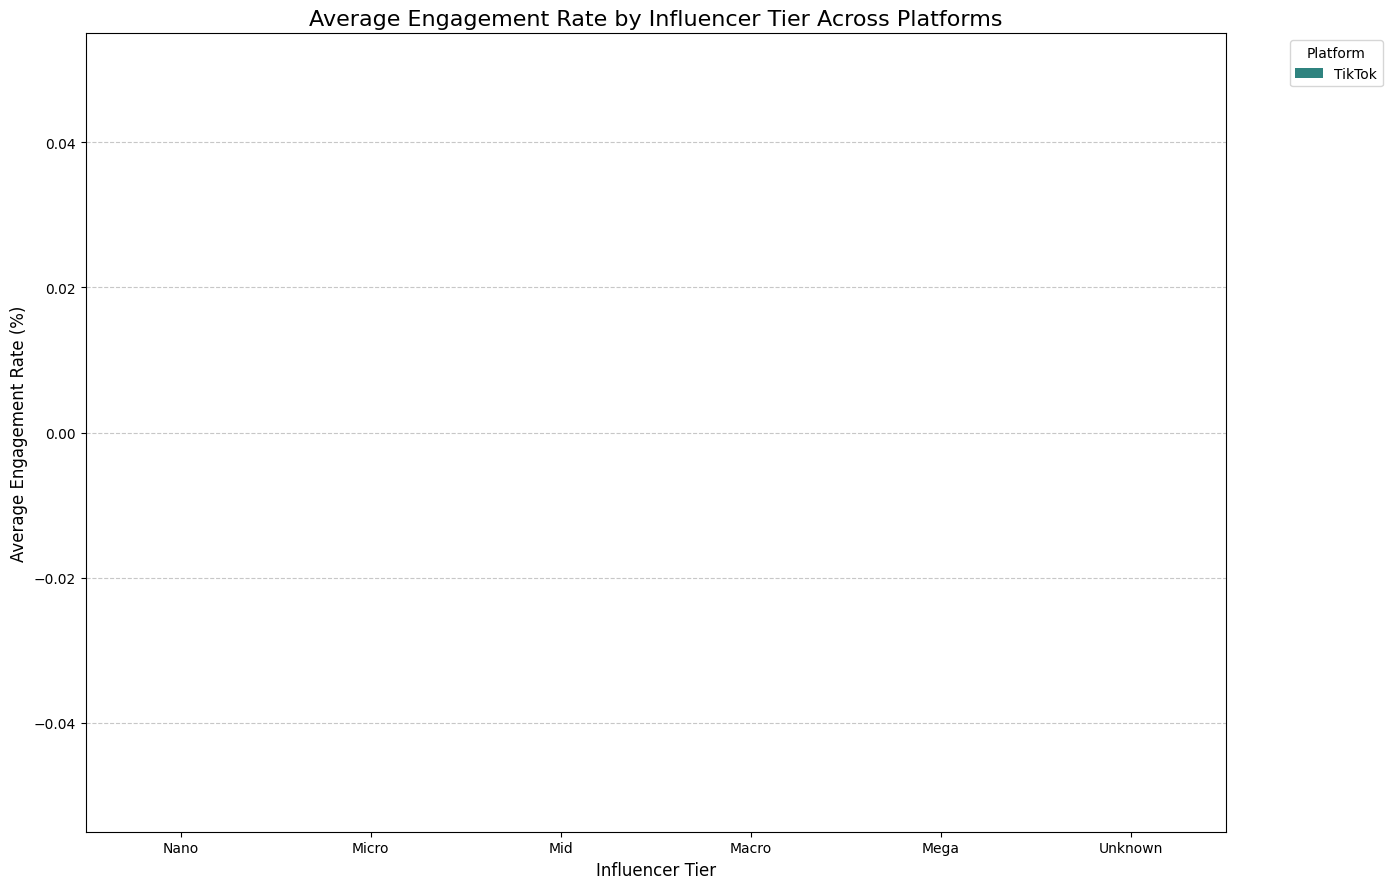


--- Influencer Tier-Specific Engagement Analysis Complete ---


In [2]:
import re # For regular expressions in cleaning

# --- Helper Function for Cleaning Numeric Columns (Handles 'K', 'M' suffixes) ---
def clean_numeric_column(series):
    """
    Cleans a pandas Series by converting values with 'K' or 'M' suffixes to numeric.
    Handles NaNs and non-numeric values by coercing them to NaN.
    """
    if not pd.api.types.is_numeric_dtype(series):
        s = series.astype(str).str.strip().str.upper()
        def convert_value(value):
            if pd.isna(value) or value in ['NAN', 'NONE', '']:
                return np.nan
            value = value.replace(',', '')
            if 'M' in value:
                return float(value.replace('M', '')) * 1_000_000
            elif 'K' in value:
                return float(value.replace('K', '')) * 1_000
            else:
                # Remove any non-digit/non-dot characters that might remain before conversion
                cleaned_value = re.sub(r'[^\d\.]', '', value)
                return pd.to_numeric(cleaned_value, errors='coerce')
        return s.apply(convert_value)
    else:
        return pd.to_numeric(series, errors='coerce')

# --- Helper Function to Calculate Engagement Rate ---
def calculate_engagement_rate(row, sub_col_name, likes_col_name, comments_col_name, shares_col_name=None):
    """
    Calculates a simplified engagement rate.
    Formula: (Average Likes + Average Comments + Average Shares) / Subscribers * 100
    Handles potential NaN values and division by zero.
    """
    subscribers = row.get(sub_col_name)
    likes = row.get(likes_col_name, 0)
    comments = row.get(comments_col_name, 0)
    shares = row.get(shares_col_name, 0) if shares_col_name else 0
    
    likes = 0 if pd.isna(likes) else float(likes)
    comments = 0 if pd.isna(comments) else float(comments)
    shares = 0 if pd.isna(shares) else float(shares)
    
    subscribers = pd.to_numeric(subscribers, errors='coerce')

    if pd.isna(subscribers) or subscribers == 0:
        return np.nan
    
    total_interactions = likes + comments + shares
    return (total_interactions / subscribers) * 100

# --- Helper Function to Assign Influencer Tiers ---
def assign_influencer_tier(df, sub_col_name, tier_thresholds):
    """
    Assigns an influencer tier based on subscriber count.
    Args:
        df (pd.DataFrame): The DataFrame.
        sub_col_name (str): The name of the subscriber column.
        tier_thresholds (dict): A dictionary mapping tier names to (min_subscribers, max_subscribers) tuples.
                                Example: {'Nano': (0, 10000), 'Micro': (10000, 100000), ...}
    Returns:
        pd.DataFrame: The DataFrame with an added 'tier' column.
    """
    df['tier'] = 'Unknown' # Default value
    
    # Sort tiers by their min threshold to ensure correct assignment
    sorted_tiers = sorted(tier_thresholds.items(), key=lambda item: item[1][0])

    for tier_name, (lower_bound, upper_bound) in sorted_tiers:
        # For the highest tier (e.g., Mega), upper_bound can be effectively infinity
        if upper_bound is None:
            df.loc[(df[sub_col_name] >= lower_bound), 'tier'] = tier_name
        else:
            df.loc[(df[sub_col_name] >= lower_bound) & (df[sub_col_name] < upper_bound), 'tier'] = tier_name
            
    # Ensure 'Unknown' for NaNs in subscriber count
    df.loc[df[sub_col_name].isna(), 'tier'] = 'Unknown'
    
    return df

# --- Main Analysis Function for Tier-Specific Engagement ---
def analyze_tier_engagement(
    insta_df, tiktok_df, youtube_df,
    insta_col_map={
        'subscribers': 'followers',
        'likes_avg': 'authentic_engagement',
        'comments_avg': 'engagement_average',
        'name': 'name'
    },
    tiktok_col_map={
        'subscribers': 'followers',
        'likes_avg': 'likes_avg',
        'comments_avg': 'comments_avg',
        'shares_avg': 'shares_avg',
        'name': 'name'
    },
    yt_col_map={
        'subscribers': 'subscribers',
        'likes_avg': 'avg_likes',
        'comments_avg': 'avg_comments',
        'name': 'name'
    },
    # --- CUSTOMIZE TIER THRESHOLDS HERE ---
    # You can define different thresholds for each platform if needed, or use the same.
    # The order of tiers in the dictionary does not matter, but will be sorted internally.
    # For the highest tier, use None for the upper bound (e.g., (10000000, None) for Mega)
    tier_thresholds={
        'Nano': (0, 10_000),         # 0 - 9,999 followers
        'Micro': (10_000, 100_000),   # 10,000 - 99,999 followers
        'Mid': (100_000, 1_000_000),  # 100,000 - 999,999 followers
        'Macro': (1_000_000, 10_000_000), # 1,000,000 - 9,999,999 followers
        'Mega': (10_000_000, None)    # 10,000,000+ followers
    }
):
    """
    Analyzes and visualizes average engagement rates per influencer tier for each platform.
    """
    print("--- Starting Influencer Tier-Specific Engagement Analysis ---")
    all_tier_data = []
    
    # Define a custom order for tiers for consistent plotting
    tier_order = [name for name, _ in sorted(tier_thresholds.items(), key=lambda item: item[1][0])]
    if 'Unknown' in tier_order: # Ensure Unknown is at the end if it somehow gets into the keys
        tier_order.remove('Unknown')
    tier_order.append('Unknown')


    platforms_config = {
        'Instagram': {'df': insta_df, 'col_map': insta_col_map, 'has_shares': False},
        'TikTok': {'df': tiktok_df, 'col_map': tiktok_col_map, 'has_shares': True},
        'YouTube': {'df': youtube_df, 'col_map': yt_col_map, 'has_shares': False}
    }

    for platform, config in platforms_config.items():
        df = config['df']
        col_map = config['col_map']
        has_shares = config['has_shares']

        if df is None or df.empty:
            print(f"\nSkipping {platform}: DataFrame is either None or empty.")
            continue

        # Check for essential columns based on the provided map
        sub_col = col_map.get('subscribers')
        likes_col = col_map.get('likes_avg')
        comments_col = col_map.get('comments_avg')
        shares_col = col_map.get('shares_avg') if has_shares else None
        
        essential_cols = [sub_col, likes_col, comments_col]
        if shares_col: essential_cols.append(shares_col)
        
        missing_cols = [col for col in essential_cols if col is None or col not in df.columns]
        
        if missing_cols:
            print(f"\nSkipping {platform}: Missing essential columns for analysis: {missing_cols}. Please check your column mappings.")
            print(f"Available columns: {df.columns.tolist()}")
            continue

        # --- Data Cleaning and Calculation ---
        df_processed = df.copy()
        for col in [sub_col, likes_col, comments_col, shares_col]:
            if col and col in df_processed.columns:
                df_processed[col] = clean_numeric_column(df_processed[col])

        df_processed['engagement_rate'] = df_processed.apply(
            lambda row: calculate_engagement_rate(row, sub_col, likes_col, comments_col, shares_col),
            axis=1
        )
        
        # --- Assign Tiers ---
        df_processed = assign_influencer_tier(df_processed, sub_col, tier_thresholds)

        # Drop rows where engagement rate or tier couldn't be determined
        df_processed.dropna(subset=['engagement_rate'], inplace=True)
        df_processed = df_processed[df_processed['tier'] != 'Unknown'] # Filter out unknown tiers
        
        if df_processed.empty:
            print(f"\nNo valid tier-specific engagement data for {platform} after cleaning. Skipping.")
            continue
        
        df_processed['platform'] = platform
        all_tier_data.append(df_processed[['platform', 'tier', 'engagement_rate']])

        # Print summary for current platform
        print(f"\n--- {platform} Average Engagement Rate by Tier ---")
        avg_engagement_by_tier = df_processed.groupby('tier')['engagement_rate'].mean().reindex(tier_order, fill_value=np.nan)
        print(avg_engagement_by_tier.round(2).to_string())

    # --- Combined Visualization ---
    if all_tier_data:
        combined_df = pd.concat(all_tier_data, ignore_index=True)
        
        # Filter out platforms that somehow still ended up with no data after concat
        valid_platforms_in_plot = combined_df.groupby('platform')['engagement_rate'].count() > 1
        combined_df_to_plot = combined_df[combined_df['platform'].isin(valid_platforms_in_plot[valid_platforms_in_plot].index)]

        if not combined_df_to_plot.empty:
            plt.figure(figsize=(14, 9))
            sns.barplot(
                x='tier',
                y='engagement_rate',
                hue='platform',
                data=combined_df_to_plot,
                order=tier_order, # Ensure consistent tier order on x-axis
                palette='viridis',
                errorbar='sd' # Show standard deviation
            )
            plt.title('Average Engagement Rate by Influencer Tier Across Platforms', fontsize=16)
            plt.xlabel('Influencer Tier', fontsize=12)
            plt.ylabel('Average Engagement Rate (%)', fontsize=12)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.legend(title='Platform', bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.tight_layout()
            plt.show()
        else:
            print("\nNo valid data for plotting after filtering for platforms with enough data points.")
    else:
        print("\nNo tier-specific engagement data to visualize across any platforms.")

    print("\n--- Influencer Tier-Specific Engagement Analysis Complete ---")


# --- EXAMPLE DATA LOADING (REPLACE WITH YOUR ACTUAL DATA) ---
# Ensure your CSV files are in the same directory or provide full paths.
# Also, ensure 'name' column exists or update the map accordingly.

try:
    insta_df = pd.read_csv('./Clean_Data/merged_instagram_data_cleaned.csv')
    # Pre-clean crucial columns to help robustness for this specific analysis
    # In the EXAMPLE DATA LOADING section:
    insta_df['subscribers_count'] = clean_numeric_column(insta_df['subscribers_count']) # Change 'followers' to the actual name
    insta_df['followers'] = clean_numeric_column(insta_df['followers']) # Example: your subs column
    insta_df['authentic_engagement'] = clean_numeric_column(insta_df['authentic_engagement'])
    insta_df['engagement_average'] = clean_numeric_column(insta_df['engagement_average'])
    print("Instagram data loaded and pre-cleaned.")
except FileNotFoundError:
    print("ERROR: 'instagram_data.csv' not found. Please check the file path.")
    insta_df = None
except Exception as e:
    print(f"ERROR loading and pre-cleaning Instagram data: {e}")
    insta_df = None

try:
    tiktok_df = pd.read_csv('./Clean_Data/merged_tiktok_data_cleaned.csv')
    tiktok_df['followers'] = clean_numeric_column(tiktok_df['followers']) # Example: your subs column
    tiktok_df['likes_avg'] = clean_numeric_column(tiktok_df['likes_avg'])
    tiktok_df['comments_avg'] = clean_numeric_column(tiktok_df['comments_avg'])
    tiktok_df['shares_avg'] = clean_numeric_column(tiktok_df['shares_avg'])
    print("TikTok data loaded and pre-cleaned.")
except FileNotFoundError:
    print("ERROR: 'tiktok_data.csv' not found. Please check the file path.")
    tiktok_df = None
except Exception as e:
    print(f"ERROR loading and pre-cleaning TikTok data: {e}")
    tiktok_df = None

try:
    youtube_df = pd.read_csv('./Clean_Data/merged_youtube_data_cleaned.csv')
    youtube_df['subscribers'] = clean_numeric_column(youtube_df['subscribers']) # Example: your subs column
    youtube_df['avg_likes'] = clean_numeric_column(youtube_df['avg_likes'])
    youtube_df['avg_comments'] = clean_numeric_column(youtube_df['avg_comments'])
    print("YouTube data loaded and pre-cleaned.")
except FileNotFoundError:
    print("ERROR: 'youtube_data.csv' not found. Please check the file path.")
    youtube_df = None
except Exception as e:
    print(f"ERROR loading and pre-cleaning YouTube data: {e}")
    youtube_df = None

# --- CALL THE TIER ENGAGEMENT ANALYSIS FUNCTION ---
# --- IMPORTANT: UPDATE THE COLUMN MAPPINGS TO MATCH YOUR DATASET HEADERS ---
# The keys ('subscribers', 'likes_avg', etc.) are standardized, but the values
# (e.g., 'followers', 'authentic_engagement') MUST match your column names.
analyze_tier_engagement(
    insta_df=insta_df,
    tiktok_df=tiktok_df,
    youtube_df=youtube_df,
    # In the analyze_tier_engagement function call:
    insta_col_map={
        'subscribers': 'subscribers_count', # <--- CHANGE THIS to the actual name
        'likes_avg': 'authentic_engagement',
        'comments_avg': 'engagement_average',
        'name': 'name'
    },
    tiktok_col_map={
        'subscribers': 'followers',     # <--- UPDATE THIS based on your TikTok CSV
        'likes_avg': 'likes_avg',       # <--- UPDATE THIS
        'comments_avg': 'comments_avg', # <--- UPDATE THIS
        'shares_avg': 'shares_avg',     # <--- UPDATE THIS (set to None if not available)
        'name': 'name'                  # <--- UPDATE THIS
    },
    yt_col_map={
        'subscribers': 'subscribers',   # <--- UPDATE THIS based on your YouTube CSV
        'likes_avg': 'avg_likes',       # <--- UPDATE THIS
        'comments_avg': 'avg_comments', # <--- UPDATE THIS
        'name': 'name'                  # <--- UPDATE THIS
    },
    # --- CUSTOMIZE TIER THRESHOLDS HERE IF NEEDED ---
    tier_thresholds={
        'Nano': (0, 10_000),
        'Micro': (10_000, 100_000),
        'Mid': (100_000, 1_000_000),
        'Macro': (1_000_000, 10_000_000),
        'Mega': (10_000_000, None) # 'None' indicates no upper limit
    }
)